 در این قسمت دیتاهای مورد نیازمان را تولید کرده و 30 درصد آنها را به عنوان تست استفاده کرده و مابقی را برای آموزش. سپس دیتاها را رسم کرده ایم

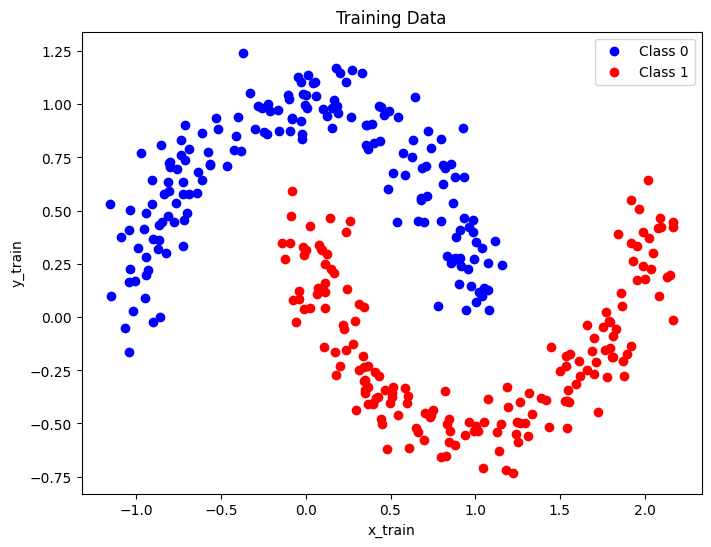

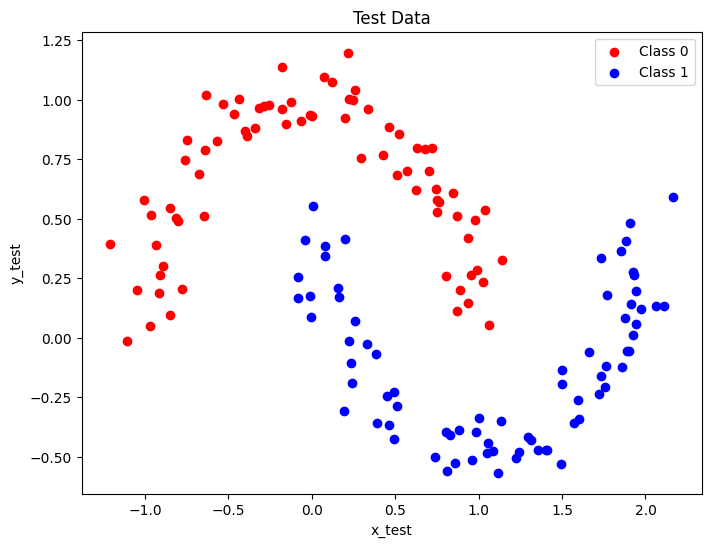

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

# Cunstruct non-linier data set   
X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Plot the training data
plt.figure(figsize=(8, 6))
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='red', label='Class 1')
plt.title('Training Data')
plt.xlabel('x_train')
plt.ylabel('y_train')
plt.legend()
plt.show()

# Plot the test data
plt.figure(figsize=(8, 6))
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color='red', label='Class 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='blue', label='Class 1')
plt.title('Test Data')
plt.xlabel('x_test')
plt.ylabel('y_test')
plt.legend()
plt.show()

# Convert data to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


در این قسمت کلاس موردنظر را پیاده سازی کرده ایم

In [30]:
class RBF(nn.Module):
    def __init__(self, num_centers, num_features):
        super(RBF, self).__init__()
        self.num_centers = num_centers
        self.num_features = num_features
        self.centers = nn.Parameter(torch.randn(num_centers, num_features))
        self.linear = nn.Linear(num_centers, 1, bias=True)
        self.sigma = nn.Parameter(torch.ones(1))

    def rbf(self, x):
        x = x.unsqueeze(1).expand(-1, self.num_centers, -1)
        centers = self.centers.unsqueeze(0).expand(x.size(0), -1, -1)
        return torch.exp(-torch.sum((x - centers) ** 2, dim=2) / (2 * self.sigma ** 2))

    def forward(self, x):
        rbf_out = self.rbf(x)
        return self.linear(rbf_out)


def train_model(model, X_train, y_train, num_epochs=100, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
    return model


در این قسمت تعدادی مدل با تعداد متفاوت توابع شعاعی در لایه مخفی آموزش داده ایم. سپس هم مقادیر خطا و هم دقت را برای هر مدل ترسیم کرده ایم. همانطور که مشاهده میکنید اگر تعداد توابع خیلی کم باشد دقت نسبتا کمتری داریم چرا که میدانیم هر کدام از این توابع به صورت محلی تصمیم گیری کرده. هنگامی که تعداد خیلی زیاد باشد در حدی که تعداد توابع برابر تعداد نمونه ها باشد مدل میتواند تابع را به صورت دقیق تقریب بزند. اما میبینید که با تعداد 30 نورون هم میتوان به دقت خوبی رسید 

Number of centers: 2, MSE: 0.14031536877155304, Accuracy: 0.7666666666666667
Number of centers: 5, MSE: 0.13019375503063202, Accuracy: 0.8
Number of centers: 10, MSE: 0.0658109039068222, Accuracy: 0.92
Number of centers: 15, MSE: 0.09510676562786102, Accuracy: 0.88
Number of centers: 20, MSE: 0.08187803626060486, Accuracy: 0.8733333333333333
Number of centers: 25, MSE: 0.06197047606110573, Accuracy: 0.92
Number of centers: 30, MSE: 0.03684088960289955, Accuracy: 0.96
Number of centers: 35, MSE: 0.07486764341592789, Accuracy: 0.9
Number of centers: 350, MSE: 0.023577185347676277, Accuracy: 1.0
Number of centers: 400, MSE: 0.023783886805176735, Accuracy: 1.0


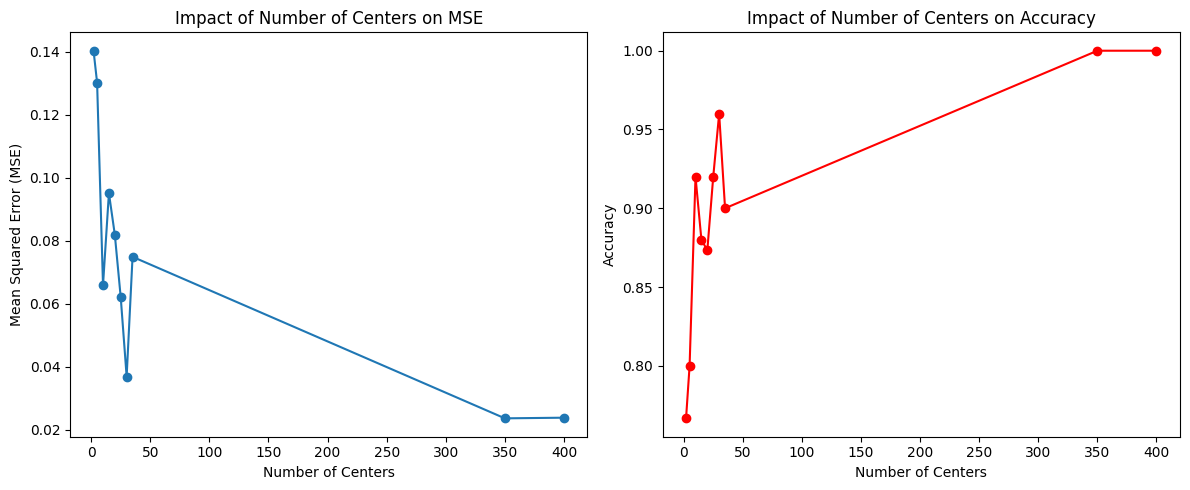

In [36]:
# create some rbf model with different centers
num_centers_list = [2, 5, 10, 15, 20, 25, 30, 35, 350, 400]
errors = []
accuracies = []

for num_centers in num_centers_list:
    rbf_model = RBF(num_centers=num_centers, num_features=2)
    rbf_model = train_model(rbf_model, X_train, y_train, num_epochs=100, learning_rate=0.01)
    rbf_model.eval()
    with torch.no_grad():
        y_pred = rbf_model(X_test)
        y_pred_labels = (y_pred > 0.5).float()  
        mse = mean_squared_error(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred_labels)
        errors.append(mse)
        accuracies.append(accuracy)
        print(f"Number of centers: {num_centers}, MSE: {mse}, Accuracy: {accuracy}")

# plot MSE and Accuract table for each rbf       
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(num_centers_list, errors, marker='o')
plt.xlabel('Number of Centers')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Impact of Number of Centers on MSE')

plt.subplot(1, 2, 2)
plt.plot(num_centers_list, accuracies, marker='o', color='r')
plt.xlabel('Number of Centers')
plt.ylabel('Accuracy')
plt.title('Impact of Number of Centers on Accuracy')

plt.tight_layout()
plt.show()


در این قسمت همانطور که مشاهده میکنید مدل دقیقا تابع مورد نظر را یادگرفته است. خروجی نمایش داده شده به وضوح این را نشان داده

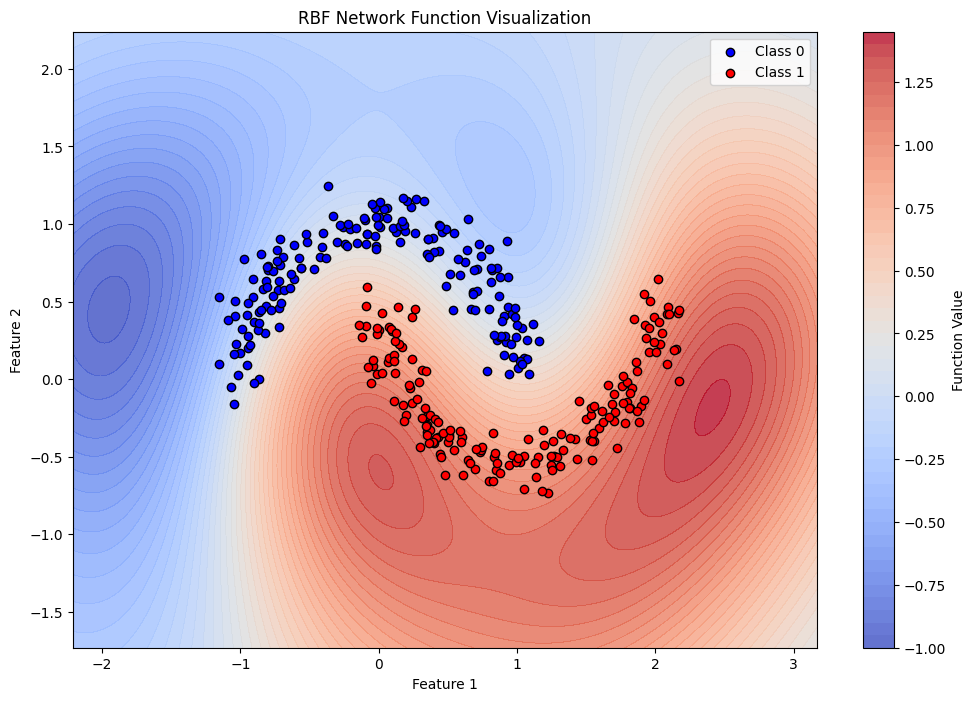

In [24]:
rbf_model = RBF(num_centers=500, num_features=2)
rbf_model = train_model(rbf_model, X_train, y_train, num_epochs=100, learning_rate=0.01)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

rbf_model.eval()
with torch.no_grad():
    Z = rbf_model(grid_points).numpy()
    Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.8)
plt.colorbar(label='Function Value')
plt.scatter(X_train[y_train.squeeze() == 0][:, 0], X_train[y_train.squeeze() == 0][:, 1], color='blue', edgecolors='k', label='Class 0')
plt.scatter(X_train[y_train.squeeze() == 1][:, 0], X_train[y_train.squeeze() == 1][:, 1], color='red', edgecolors='k', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('RBF Network Function Visualization')
plt.legend()
plt.show()

